In [16]:
from forecast.data import SalesDataModel, SalesDataGenerator
import random
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

In [17]:
# synthetic data params
num_days = 365 * 5
items = [f"Item {idx}" for idx in range(20)]
locations = [f"Location {idx}" for idx in range(5)]
item_to_class = {item: random.choice(["Item Class A", "Item Class B", "Item Class C"]) for item in items}

generator = SalesDataGenerator(
    start_date=datetime.today().date() - timedelta(days=num_days),
    num_days=num_days,
    item_to_location={item: locations for item in items},
    item_to_class=item_to_class,
    max_sales_per_day=1000,
    min_sales_per_day=-100,
)

data = generator.synthesize(data_model=SalesDataModel.SINUSOID)
data.head()

,Date,Item,Location,Sales,Item Class
0,2017-06-15,Item 0,Location 0,918,Item Class B
1,2017-06-16,Item 0,Location 0,965,Item Class B
2,2017-06-17,Item 0,Location 0,908,Item Class B
3,2017-06-18,Item 0,Location 0,971,Item Class B
4,2017-06-19,Item 0,Location 0,990,Item Class B


In [18]:
start = data.Date.min()
end = data.Date.max()
ensemble = []
dates = list(pd.date_range(start, end))
for item in set(data.Item): 
    for location in set(data.Location):
        sales = data[(data.Item == item) & (data.Location == location)].Sales.values
        if len(sales): 
            scale = max(abs(sales))
            ensemble.append(
                {
                    "class": item_to_class[item],
                    "item": item,
                    "sales": sales,
                    "start": start,
                    "end": end,
                    "total": sum(sales),
                    "scale": scale,
                    "location": location,
                    "sales_scaled": sales / scale,
                }
            )
ensemble = sorted(ensemble, key=lambda k: k["total"], reverse=True)

In [19]:
from gluonts.dataset.common import load_datasets, ListDataset
from gluonts.dataset.field_names import FieldName

In [20]:
quantity_length = len(ensemble[0]["sales"])
prediction_length = 30
context_length = 6 * prediction_length

static_cats = [(e["class"].strip(), e["item"].strip(), e["location"].strip()) for e in ensemble]

item_to_index = {item: idx for idx, item in enumerate(set([sc[0] for sc in static_cats]))}
item_class_to_index = {item: idx for idx, item in enumerate(set([sc[1] for sc in static_cats]))}
location_to_index = {loc: idx for idx, loc in enumerate(set([sc[2] for sc in static_cats]))}

test_target_values = np.array([np.array(e["sales_scaled"]) for e in ensemble])
train_target_values = np.array([np.array(e["sales_scaled"][:-prediction_length]) for e in ensemble])

In [21]:
train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_STATIC_CAT: [
            item_to_index[sc_item], 
            item_class_to_index[sc_item_class], 
            location_to_index[sc_location]
        ],
    }
    for target, (sc_item, sc_item_class, sc_location) in zip(train_target_values, static_cats)
], freq="D")

In [22]:
test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_STATIC_CAT: [
            item_to_index[sc_item], 
            item_class_to_index[sc_item_class], 
            location_to_index[sc_location]
        ],
    }
    for target, (sc_item, sc_item_class, sc_location) in zip(test_target_values, static_cats)
], freq="D")

In [23]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution.gaussian import GaussianOutput
from gluonts.mx.trainer import Trainer

estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=context_length,
    freq="D",
    num_cells = 2,
    distr_output = GaussianOutput(),
    use_feat_dynamic_real=False,
    use_feat_static_cat=True,
    cardinality=[len(item_to_index), len(item_class_to_index), len(location_to_index)],
    embedding_dimension=[32,64, 32],
    trainer=Trainer(
        learning_rate=1e-2,
        epochs=20,
        num_batches_per_epoch=10,
        clip_gradient=1.0
    )
)
predictor = estimator.train(train_ds)

/Users/chulahlou/opt/anaconda3/envs/forecast-ml/lib/python3.7/site-packages/gluonts-0.8.1-py3.7.egg/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/Users/chulahlou/opt/anaconda3/envs/forecast-ml/lib/python3.7/site-packages/gluonts-0.8.1-py3.7.egg/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/Users/chulahlou/opt/anaconda3/envs/forecast-ml/lib/python3.7/site-packages/gluonts-0.8.1-py3.7.egg/gluonts/dataset/common.py:328: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/chulahlou/opt/anaconda3/envs/forecast-ml/lib/python3.7/site-packages/gluonts-0.8.1-py3.7.egg/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will

In [24]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(dataset=test_ds, predictor=predictor, num_samples=250)
forecasts = [f for f in forecast_it]
tss = list(ts_it)

In [25]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
metrics, _ = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
metrics = pd.DataFrame.from_records(metrics, index=["DeepAR"]).transpose()
metrics

Running evaluation: 100%|███████████████████| 100/100 [00:00<00:00, 1199.59it/s]/Users/chulahlou/opt/anaconda3/envs/forecast-ml/lib/python3.7/site-packages/gluonts-0.8.1-py3.7.egg/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/Users/chulahlou/opt/anaconda3/envs/forecast-ml/lib/python3.7/site-packages/gluonts-0.8.1-py3.7.egg/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/Users/chulahlou/opt/anaconda3/envs/forecast-ml/lib/python3.7/site-packages/gluonts-0.8.1-py3.7.egg/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/Users/chulahlou/opt/anaconda3/envs/forecast-ml/lib/python3.7/sit

,DeepAR
Coverage[0.1],0.020333
Coverage[0.5],0.224667
Coverage[0.9],0.636667
MAE_Coverage,0.206111
MAPE,0.096251
MASE,2.529557
MSE,0.013126
MSIS,17.609584
ND,0.096964
NRMSE,0.121472


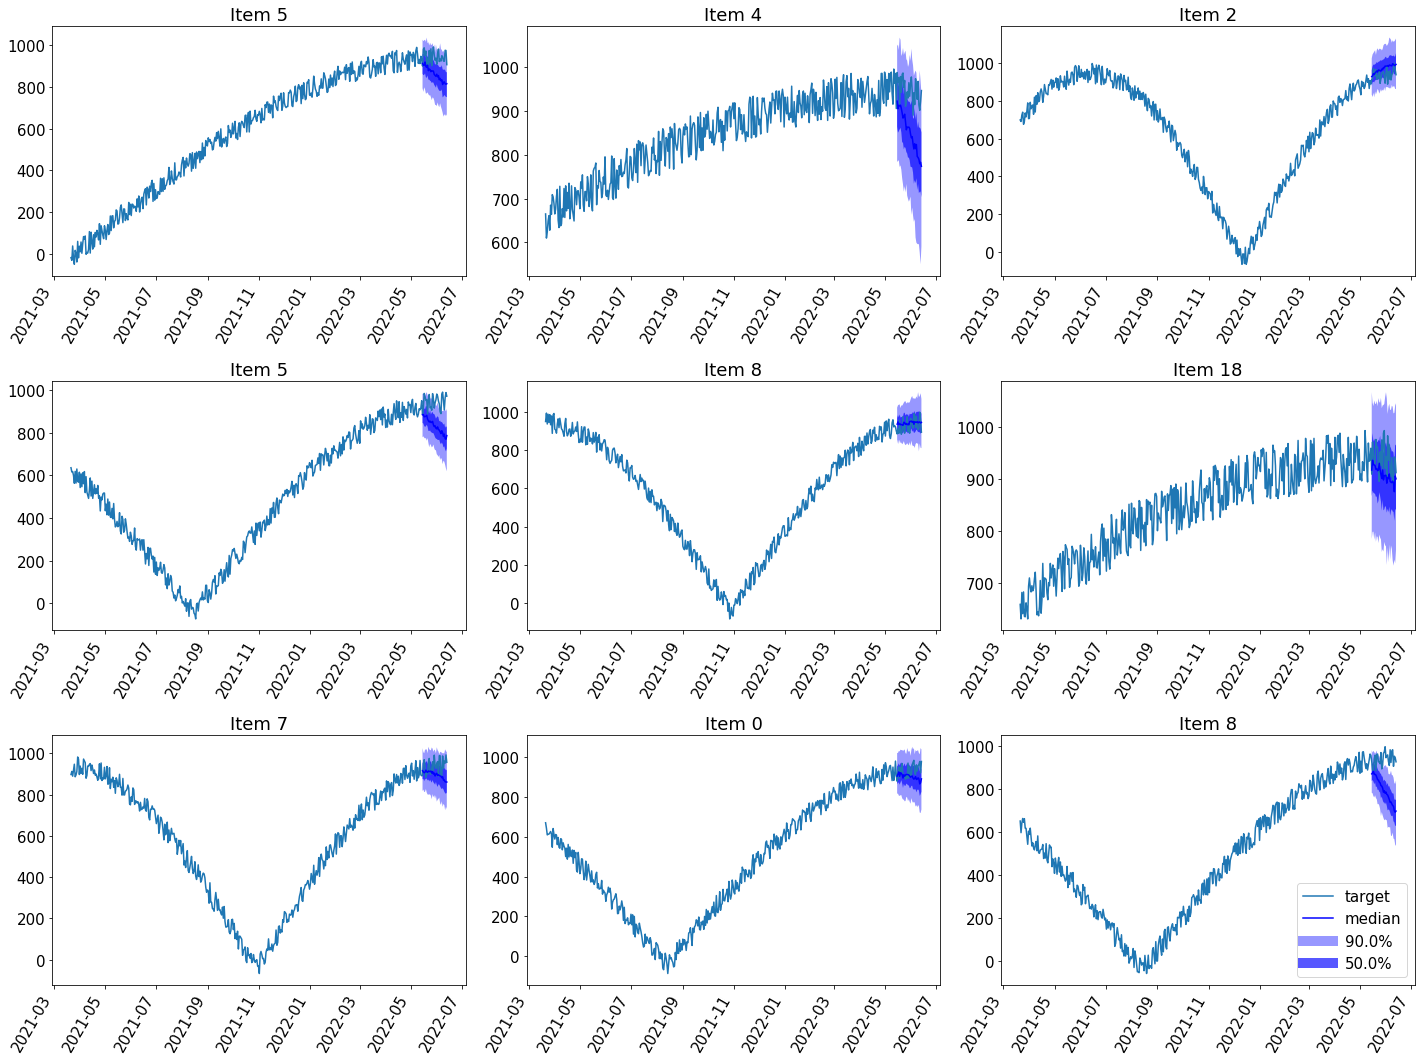

In [26]:
import copy
import matplotlib.pyplot as plt
from itertools import islice
plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

for idx, (f, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ensemble[idx]['scale'] * ts[-15 * prediction_length:], label="target")
    f2 = copy.deepcopy(f)
    f2.samples *= ensemble[idx]['scale']
    f2.plot()
    plt.xticks(rotation=60)
    plt.title(f"{ensemble[idx]['item']}")

plt.gcf().tight_layout()
plt.legend()
plt.show()